In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout

In [2]:
end = date.today()
start = date(end.year - 20, end.month, end.day)
stock_symbol = 'GOOG'
data = yf.download(stock_symbol, start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.reset_index(inplace=True)


In [4]:
ma_100_days = data['Close'].ewm(span=100, adjust=False).mean()
ma_200_days = data['Close'].ewm(span=200, adjust=False).mean()

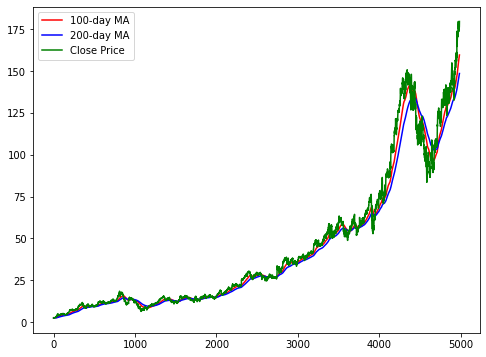

In [5]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r', label='100-day MA')
plt.plot(ma_200_days, 'b', label='200-day MA')
plt.plot(data.Close, 'g', label='Close Price')
plt.legend()
plt.show()

In [6]:
data.dropna(inplace=True)


In [7]:
data_train = pd.DataFrame(data.Close[0: int(len(data)* 0.8)])
data_test = pd.DataFrame(data.Close[int(len(data) * 0.80): len(data)])

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)

In [9]:
# Create sequences for CNN
x = []
y = []
for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i, 0])
    y.append(data_train_scale[i, 0])
x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [20]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal', input_shape=(x.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', dilation_rate=2, padding='causal'))
model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', dilation_rate=4, padding='causal'))
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', dilation_rate=8, padding='causal'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1))

In [22]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [23]:
history = model.fit(x, y, epochs=100, batch_size=32, verbose=1, validation_split=0.2)


Epoch 1/100
98/98 [==============================] - 12s 100ms/step - loss: 0.0054 - val_loss: 0.0226
Epoch 2/100
98/98 [==============================] - 11s 112ms/step - loss: 8.7062e-04 - val_loss: 0.0164
Epoch 3/100
98/98 [==============================] - 8s 83ms/step - loss: 8.8337e-04 - val_loss: 0.0086
Epoch 4/100
98/98 [==============================] - 9s 88ms/step - loss: 8.9820e-04 - val_loss: 0.0096
Epoch 5/100
98/98 [==============================] - 10s 105ms/step - loss: 7.2573e-04 - val_loss: 0.0348
Epoch 6/100
98/98 [==============================] - 9s 91ms/step - loss: 6.1684e-04 - val_loss: 0.0292
Epoch 7/100
98/98 [==============================] - 9s 89ms/step - loss: 6.6772e-04 - val_loss: 0.0529
Epoch 8/100
98/98 [==============================] - 9s 96ms/step - loss: 7.6458e-04 - val_loss: 0.0452
Epoch 9/100
98/98 [==============================] - 9s 88ms/step - loss: 5.5007e-04 - val_loss: 0.0283
Epoch 10/100
98/98 [==============================] - 8s 81ms/

In [24]:
past_100_days = data_train.tail(100)
data_test = pd.concat([past_100_days, data_test], ignore_index=True)
data_test_scale = scaler.transform(data_test)

In [25]:
x_test = []
y_test = []
for i in range(100, data_test_scale.shape[0]):
    x_test.append(data_test_scale[i-100:i, 0])
    y_test.append(data_test_scale[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [26]:
y_pred = model.predict(x_test)


35/35 [==============================] - 1s 23ms/step


In [27]:
y_pred = scaler.inverse_transform(y_pred)


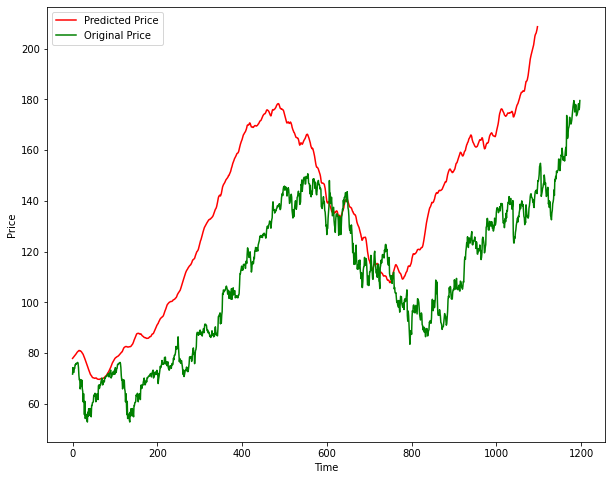

In [28]:
plt.figure(figsize=(10, 8))
plt.plot(y_pred, 'r', label='Predicted Price')
plt.plot(data_test['Close'].values, 'g', label='Original Price')
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [29]:
model.save("TCN_Stock_Prediction_Model.keras")

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 100, 128)          768       
                                                                 
 dropout_4 (Dropout)         (None, 100, 128)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 100, 128)          82048     
                                                                 
 dropout_5 (Dropout)         (None, 100, 128)          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 100, 128)          82048     
                                                                 
 dropout_6 (Dropout)         (None, 100, 128)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 100, 128)         